In [0]:
# checking on csv file with esre labeling
import operator
import os
import pprint
import glob

import string
import math
from collections import Counter
from itertools import islice

import pandas as pd
import numpy as np
import csv

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords

import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier  
from sklearn import neighbors
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

pd.options.mode.chained_assignment = None

tr = str.maketrans("", "", string.punctuation)

In [0]:
stopword = pd.read_csv('../Dataset/stopword.csv', encoding = "ISO-8859-1")
stopword = stopword[stopword['stopword'] == 1]
stopword = stopword['term'].tolist()
stopwords = stopwords.words('english')
stopwords.extend(stopword)

In [0]:
# load and preprocess post data 
def get_dataframe(dataframe, train_test = False):
    # load data
    df = pd.read_csv(dataframe, encoding = "ISO-8859-1")
    # get labelled posts
    if(train_test):
        df_label = df[(df['author'] != '[deleted]') & (df['ESRE'].notnull()) & (df['selftext'].notnull())]
    else:
         df_label = df[(df['author'] != '[deleted]') & (df['selftext'].notnull())]
    df_label.columns.values
    df_label['fulltext'] = ' ' + df_label.title + '\n ' + df_label.author +'\n ' + df_label.selftext
    #remove punctuation marks
    df_label = df_label[df_label['fulltext'].notnull()]
    df_label['fulltext'] = df_label.fulltext.apply(lambda x: x.translate(tr))
    df_label['tokenized_text'] = df_label.fulltext.apply(lambda x: nltk.word_tokenize(x))
    df_label['tokenized_text'] = df_label.tokenized_text.apply(lambda x: [y.lower() for y in x])
    # tokenizing and stemming post content
    stemmer = SnowballStemmer("english")
    df_label['stemmed_text'] = df_label.tokenized_text.apply(lambda x: [stemmer.stem(y) for y in x])
    df_label['document'] = df_label.stemmed_text.map(lambda x: ' '.join([y for y in x]))
    df_label.reset_index(drop=True,inplace=True)
    if 'ESRE' in df_label:
        df_label['ESRE'] = df_label.ESRE.apply(lambda x: int(x))
    return df_label

def get_cvec_counts_summary(cvec):
    print('sparse matrix shape:', cvec.shape)
    print('nonzero count:', cvec.nnz)
    print('sparsity: %.2f%%' % (100.0 * cvec.nnz / (cvec.shape[0] * cvec.shape[1])))
    
def get_unlabelled_dataframe(data):
    # load data
    df = pd.read_csv('dataset/loseit_posts_'+data+'.csv', encoding = "ISO-8859-1")
    # filter deleted posts
    df = df[(df['author'] != '[deleted]') & (df['selftext'].notnull())]
    
    df['fulltext'] = df.title + '\n ' + df.author +'\n ' + df.selftext
    #remove punctuation marks
    df['fulltext'] = df.fulltext.apply(lambda x: x.translate(tr))
    df['tokenized_text'] = df.fulltext.apply(lambda x: nltk.word_tokenize(x))
    df['tokenized_text'] = df.tokenized_text.apply(lambda x: [y.lower() for y in x])
    # tokenizing and stemming post content
    stemmer = SnowballStemmer("english")
    df['stemmed_text'] = df.tokenized_text.apply(lambda x: [stemmer.stem(y) for y in x])
    df['document'] = df.stemmed_text.map(lambda x: ' '.join([y for y in x]))
    df.reset_index(drop=True,inplace=True)
    return df

def get_predicted_scores(pipeline):
    pl = pipelines[pipeline].fit(df_train.document, train_target)
    predicted = pl.predict(df_test.document)
    accuracy = accuracy_score(test_target, predicted)
    precision = precision_score(test_target, predicted, average='weighted')
    recall = recall_score(test_target, predicted, average='weighted')
    f1 = f1_score(test_target, predicted, average='weighted')
    return [pipeline, precision, recall, f1, accuracy]

In [0]:
# get test and train set
df_train = get_dataframe('dataset/loseit_posts_2018_02(esre).csv', train_test = True)
df_test = get_dataframe('dataset/loseit_posts_2017_11(esre).csv', train_test = True)
train_target = df_train['ESRE']
test_target = df_test['ESRE']

In [0]:
# set piplines for each machine learning model

text_clf_nb = Pipeline([('vect', CountVectorizer(stop_words=stopwords, ngram_range = (1, 3))), ('tfidf', TfidfTransformer()),\
                        ('clf', BernoulliNB())])
text_clf_dt = Pipeline([('vect', CountVectorizer(stop_words=stopwords, ngram_range = (1, 3))), ('tfidf', TfidfTransformer()),\
                        ('clf-dt', tree.DecisionTreeClassifier())])
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words=stopwords, ngram_range = (1, 3))), ('tfidf', TfidfTransformer()),\
                         ('clf-dt', svm.SVC(kernel='linear', C=2, gamma = 0.1))])
text_clf_knn = Pipeline([('vect', CountVectorizer(stop_words = 'english', ngram_range = (1, 3))), ('tfidf', TfidfTransformer()), \
                         ('clf-dt', KNeighborsClassifier(n_neighbors=7))])
text_clf_sgd = Pipeline([('vect', CountVectorizer(stop_words=stopwords, ngram_range = (1, 3))), ('tfidf', TfidfTransformer()), \
                         ('clf-sgd', SGDClassifier(loss='perceptron', penalty='l1', alpha=1e-5, max_iter=29, random_state=42, shuffle=True))])

pipelines = {
    'naive bayes': text_clf_nb, 
    'decision tree': text_clf_dt, 
    'svm': text_clf_svm, 
    'knn': text_clf_knn, 
    'sgd': text_clf_sgd
             }

# results were...
# 2nd
# text_clf_sgd = Pipeline([('vect', CountVectorizer(stop_words=stopwords, ngram_range = (1, 4))), ('tfidf', TfidfTransformer()), \
#                          ('clf-sgd', SGDClassifier(loss='modified_huber', penalty='l1', alpha=1e-4, max_iter=23, random_state=42, shuffle=True))])
# 1st
# text_clf_sgd = Pipeline([('vect', CountVectorizer(stop_words=stopwords, ngram_range = (1, 3))), ('tfidf', TfidfTransformer()), \
#                          ('clf-sgd', SGDClassifier(loss='perceptron', penalty='l1', alpha=1e-5, max_iter=29, random_state=42, shuffle=True))])
# 3rd
# text_clf_sgd = Pipeline([('vect', CountVectorizer(stop_words=stopwords, ngram_range = (1, 3))), ('tfidf', TfidfTransformer()), \
#                          ('clf-sgd', SGDClassifier(loss='squared_hinge', penalty='l1', alpha=0.0001, max_iter=96, random_state=42, shuffle=True))])

In [0]:
# load all unlabelled data
data_name = ['2015_12', '2016_01', '2016_02', \
             '2016_03', '2016_04', '2016_05', '2016_06', '2016_07', '2016_08', '2016_09', \
             '2016_10', '2016_11', '2016_12', '2017_01', '2017_02', '2017_03', '2017_04', \
             '2017_05', '2017_06', '2017_07', '2017_08', '2017_09', '2017_10', '2017_11', \
             '2017_12', '2018_01', '2018_02']

df_unlabelled = pd.DataFrame()
for data in data_name:
    dataframe = get_unlabelled_dataframe(data)
    df_unlabelled = df_unlabelled.append(dataframe)
    df_unlabelled_shape = df_unlabelled.shape
    df_unlabelled_nrow = df_unlabelled_shape[0]
    df_unlabelled_ncol = df_unlabelled_shape[1]
    print("datafile added: ", data, " total number of columns: ", df_unlabelled_ncol, " total number of rows: ", df_unlabelled_nrow)
df_unlabelled.head()

df_total = pd.DataFrame()
for data in data_name:
    dataframe = pd.read_csv('../Dataset/loseit_posts_'+data+'.csv', encoding = "ISO-8859-1")
    df_total = df_total.append(dataframe)
df_total.shape

datafile added:  2015_12  total number of columns:  37  total number of rows:  2224
datafile added:  2016_01  total number of columns:  37  total number of rows:  5286
datafile added:  2016_02  total number of columns:  37  total number of rows:  7984
datafile added:  2016_03  total number of columns:  37  total number of rows:  10689
datafile added:  2016_04  total number of columns:  37  total number of rows:  13316
datafile added:  2016_05  total number of columns:  37  total number of rows:  15932
datafile added:  2016_06  total number of columns:  37  total number of rows:  18612
datafile added:  2016_07  total number of columns:  37  total number of rows:  21485
datafile added:  2016_08  total number of columns:  37  total number of rows:  24522
datafile added:  2016_09  total number of columns:  37  total number of rows:  27363
datafile added:  2016_10  total number of columns:  37  total number of rows:  30252
datafile added:  2016_11  total number of columns:  37  total number

(104727, 33)

In [0]:
unlabelled_documents = df_unlabelled['document'].tolist()

In [0]:
# label data on sgd model
df_sgd_result = pd.DataFrame({'ESRE': text_clf_sgd.predict(df_unlabelled.document)})
df_sgd = df_unlabelled
df_sgd['ESRE'] = df_sgd_result['ESRE']
df_sgd.reset_index(drop=True,inplace=True)
df_sgd.to_csv('dataset/results/esre_sgd_result.tsv', sep = '\t')

In [0]:
# grid searching for best rate in SDG classifier, adjusting parameters
sgd_error_rate = pd.DataFrame(columns = ['loss function','ngram', 'penalty', 'alpha', 'precision', 'pre_pos', 'pre_neg', ' recall', 'recall_pos','recall_neg', 'f1', 'f1_pos', 'f1_neg', 'minimnum error rate', 'iteration level'])

loss_functions = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
penalties = ['none', 'l2', 'l1', 'elasticnet']
ngrams = [(1, 1), (1, 2), (1, 3), (1, 4)]
alphas = [1e-4, 1e-5, 1e-6]
for ngram in ngrams:
    for penalty in penalties:
        for loss_function in loss_functions:
            for alpha_n in alphas:
                error_sgd = []
                for i in range(1, 100):  
                    clf = Pipeline([('vect', CountVectorizer(stop_words = stoplist, ngram_range = ngram)), ('tfidf', TfidfTransformer()), \
                                     ('clf-sgd', SGDClassifier( loss=loss_function, penalty=penalty, alpha=alpha_n, max_iter=i, random_state=42, shuffle=True))])
                    clf = clf.fit(df_train.document, df_train.esre)
                    pred_i = clf.predict(df_test.document)
                    error_sgd.append(np.mean(pred_i != df_test.esre))

                ngram_str = str(clf.named_steps['vect'].ngram_range)
                
                clf = Pipeline([('vect', CountVectorizer(stop_words = stoplist, ngram_range = ngram)), ('tfidf', TfidfTransformer()), \
                                     ('clf-sgd', SGDClassifier(loss=loss_function, penalty=penalty, alpha=alpha_n, max_iter=error_sgd.index(min(error_sgd))+1, random_state=42, shuffle=True))])
                clf.fit(df_train.document, df_train.esre)
                pred = clf.predict(df_test.document)

                precision_tot = precision_score(test_target, pred, average='weighted') 
                precision_pos = precision_score(test_target, pred, average='binary', pos_label = 1)
                precision_neg = precision_score(test_target, pred, average='binary', pos_label = 0)
                recall_tot = recall_score(test_target, pred, average='weighted')
                recall_pos = recall_score(test_target, pred, average='binary', pos_label = 1)
                recall_neg = recall_score(test_target, pred, average='binary', pos_label = 0)
                f1_tot = f1_score(test_target, pred, average='weighted')
                f1_pos = f1_score(test_target, pred, average='binary', pos_label = 1)
                f1_neg = f1_score(test_target, pred, average='binary', pos_label = 0)
                
                sgd_error_rate.loc[len(sgd_error_rate)] = [loss_function, ngram_str, penalty, alpha_n, precision_tot, \
                precision_pos, precision_neg, recall_tot, recall_pos, recall_neg, f1_tot, f1_pos, f1_neg, min(error_sgd), error_sgd.index(min(error_sgd))+1]
                print(sgd_error_rate)
                print('\n')
        
sgd_error_rate.to_csv('../dataset/results/grid_search_sgd/sgd_error_rate.csv')

Error rate for loss function: squared_hinge , alpha:0.0001 & penalty: l1 is : 0.0857142857143 at iteration level 96 . Acutal number of iteration is 99


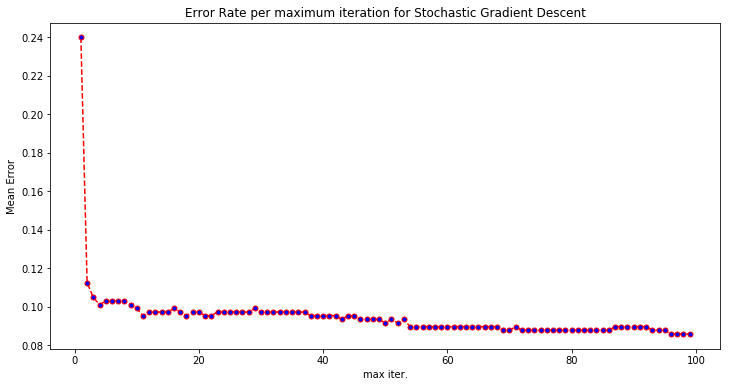

In [0]:
# plot learning curve on matplotlib
error_sgd = []
vectorizer = text_clf_sgd.named_steps['vect']
classifier = text_clf_sgd.named_steps['clf-sgd']
loss_function = classifier.loss
ngram = vectorizer.ngram_range
penalty = classifier.penalty
alpha_n = classifier.alpha
for i in range(1, 100):  
    clf = Pipeline([('vect', CountVectorizer(stop_words = stopwords, ngram_range = ngram)), 
                    ('tfidf', TfidfTransformer()), 
                    ('clf-sgd', SGDClassifier( loss=loss_function, penalty=penalty, alpha=alpha_n, max_iter=i, random_state=42, shuffle=True))])
    clf = clf.fit(df_train.document, df_train.ESRE)
    pred_i = clf.predict(df_test.document)
    error_sgd.append(np.mean(pred_i != df_test.ESRE))

ngram_str = str(clf.named_steps['vect'].ngram_range)

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 100), error_sgd, color='red', linestyle='dashed', marker='o',\
         markerfacecolor='blue', markersize=5)
plt.title('Error Rate per maximum iteration for Stochastic Gradient Descent')  
plt.xlabel('max iter.')  
plt.ylabel('Mean Error')  
print('Error rate for loss function:', loss_function, ', alpha:' + str(alpha_n) + ' & penalty:', penalty,'is :', min(error_sgd),'at iteration level', error_sgd.index(min(error_sgd))+1,'. Acutal number of iteration is', clf.named_steps['clf-sgd'].n_iter_)
plt.show()

In [0]:
result = df_sgd[['created_utc','document', 'id', 'ESRE']]

In [0]:
def indexing_dataframe(df, idx, text):
    with open('dataset/results/text_index/' + str(idx), "w") as text_file:
        text_file.write(text)

In [0]:
result = result.drop('document', axis=1)
result.to_csv('dataset/results/ESRE_result_id.csv')